In [1]:
import sys
sys.path.append('../scripts')

import os
import numpy as np
import pandas as pd
import pickle
import random
import json

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D

from maml.models import AtomSetsReg, MLP
import keras as keras
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

from model_training import set_reproducibility 

import warnings

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
keras.utils.set_random_seed(seed)
random.seed(seed)

warnings.filterwarnings("ignore")

C:\Users\mchaf\miniconda3\envs\maml_developer\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Define paths for relevant directories

In [4]:
labelled_conductivity_database_features_path = r"..\data\graph_based_features_wo_duplicates.pkl"
test_split_path = r"..\data\training_validation_testing_splits\classification\test\test.csv"
model_ensemble_filepath = r"..\data\final_models_camns_level1_n1_pr_auc_nepochs183"
atomistic_results_filepath = r"..\data\atomistic_lococv_results.pkl"
atomistic_feature_path = r"..\data\atomistic_features.pkl"

### Load Test data split and corresponding features

In [5]:
labelled_conductivity_database_features = pd.read_pickle(labelled_conductivity_database_features_path)
test_split_df = pd.read_csv(test_split_path)
feature = "structure_simplified_megnet_site_feature_level_1_2019_4_1_formation_energy"

labelled_conductivity_database_features = labelled_conductivity_database_features[['icsd_collectioncode', feature]]
test_feature_df = pd.merge(test_split_df, labelled_conductivity_database_features, on='icsd_collectioncode')
test_icsd_collectioncodes = test_feature_df['icsd_collectioncode'].unique()
train_feature_df = labelled_conductivity_database_features[~labelled_conductivity_database_features['icsd_collectioncode'].isin(test_icsd_collectioncodes)]

In [6]:
features_train = [df.to_numpy() for df in train_feature_df[feature].to_list()]
features_test = [df.to_numpy() for df in test_feature_df[feature].to_list()]

features_train_mean = [np.mean(feature_matrix, axis=0) for feature_matrix in features_train]
features_test_mean = [np.mean(feature_matrix, axis=0) for feature_matrix in features_test]

pca = PCA()
pca.fit(features_train_mean)
features_train_pca = pca.transform(features_train_mean)
variances_train = pca.explained_variance_
centroid_train_pca = np.mean(features_train_pca, axis=0)
squared_diff_train = (features_train_pca - centroid_train_pca)**2
sqrt_variances = np.sqrt(variances_train)
normalized_squared_diff_train = squared_diff_train / sqrt_variances
normalized_distances_train = np.sqrt(np.sum(normalized_squared_diff_train, axis=1))

features_test_pca = pca.transform(features_test_mean)
squared_diff_test = (features_test_pca - centroid_train_pca)**2
normalized_squared_diff_test = squared_diff_test / sqrt_variances
normalized_distances_test = np.sqrt(np.sum(normalized_squared_diff_test, axis=1))

mean_d_train = np.mean(normalized_distances_train)
normalized_distances_test /= mean_d_train

test_feature_df['normalized_distance_to_centroid'] = normalized_distances_test

normalized_distances_to_train = []

for test_point in features_test_pca:
    squared_diff_to_train = (features_train_pca - test_point)**2
    normalized_squared_diff_train = squared_diff_to_train / sqrt_variances
    distances_to_train = np.sqrt(np.sum(normalized_squared_diff_train, axis=1))
    
    min_distance = np.min(distances_to_train)
    
    normalized_distances_to_train.append(min_distance) 

normalized_distances_to_train = np.array(normalized_distances_to_train)
normalized_distances_to_train /= mean_d_train

test_feature_df['normalized_distance_to_training_point'] = normalized_distances_to_train

In [7]:
model_columns = []
predictions_list = []
models = os.listdir(model_ensemble_filepath)
for i, model_name in enumerate(models):
        print(f"Getting predictions for model {i}: {model_name}")
        model_path = os.path.join(model_ensemble_filepath, model_name, "model")
        model = AtomSetsReg.from_dir(model_path)
        pred = model._predict(test_feature_df[feature].to_list())
        predictions_list.append(pred)
        model_columns.append(model_name + "_prediction")

Getting predictions for model 0: 22b92b47_run_1
1/1 [==============================] - 1s 1s/step
Getting predictions for model 1: 22b92b47_run_10
1/1 [==============================] - 1s 820ms/step
Getting predictions for model 2: 22b92b47_run_2
1/1 [==============================] - 1s 798ms/step
Getting predictions for model 3: 22b92b47_run_3
1/1 [==============================] - 1s 819ms/step
Getting predictions for model 4: 22b92b47_run_4


1/1 [==============================] - 1s 858ms/step
Getting predictions for model 5: 22b92b47_run_5


1/1 [==============================] - 1s 825ms/step
Getting predictions for model 6: 22b92b47_run_6
1/1 [==============================] - 1s 816ms/step
Getting predictions for model 7: 22b92b47_run_7
1/1 [==============================] - 1s 838ms/step
Getting predictions for model 8: 22b92b47_run_8
1/1 [==============================] - 1s 1s/step
Getting predictions for model 9: 22b92b47_run_9
1/1 [==============================] - 1s 803ms/step
Getting predictions for model 10: 3e3dfd3c_run_1
1/1 [==============================] - 1s 745ms/step
Getting predictions for model 11: 3e3dfd3c_run_10
1/1 [==============================] - 1s 752ms/step
Getting predictions for model 12: 3e3dfd3c_run_2
1/1 [==============================] - 1s 761ms/step
Getting predictions for model 13: 3e3dfd3c_run_3
1/1 [==============================] - 1s 746ms/step
Getting predictions for model 14: 3e3dfd3c_run_4
1/1 [==============================] - 1s 736ms/step
Getting predictions for model 15: 3

In [8]:
test_predictions_df = pd.DataFrame(np.concatenate(predictions_list, axis=1), columns=model_columns)
test_predictions_df['prediction_mean'] = test_predictions_df[model_columns].mean(axis=1)
test_predictions_df['prediction_std'] = test_predictions_df[model_columns].std(axis=1)
test_predictions_df['predicted_is_superionic'] = test_predictions_df['prediction_mean'].apply(lambda x: 1 if x >= 0.5 else 0)

In [9]:
test_feature_df.reset_index(drop=True, inplace=True)
test_predictions_df = pd.concat([test_feature_df, test_predictions_df], axis=1)

In [10]:
true_labels = test_predictions_df['is_superionic']
predicted_labels = test_predictions_df['predicted_is_superionic']
predicted_probabilities = test_predictions_df['prediction_mean']

fpr, tpr, _ = roc_curve(true_labels, predicted_probabilities)
precision, recall, _ = precision_recall_curve(true_labels,predicted_probabilities)
pr_auc = auc(recall, precision)
mcc = matthews_corrcoef(true_labels, predicted_labels)

print(f"The test pr_auc score is : {pr_auc}")
print(f"The test mcc score is : {mcc}")

The test pr_auc score is : 0.8622028722139017
The test mcc score is : 0.5984063716876622


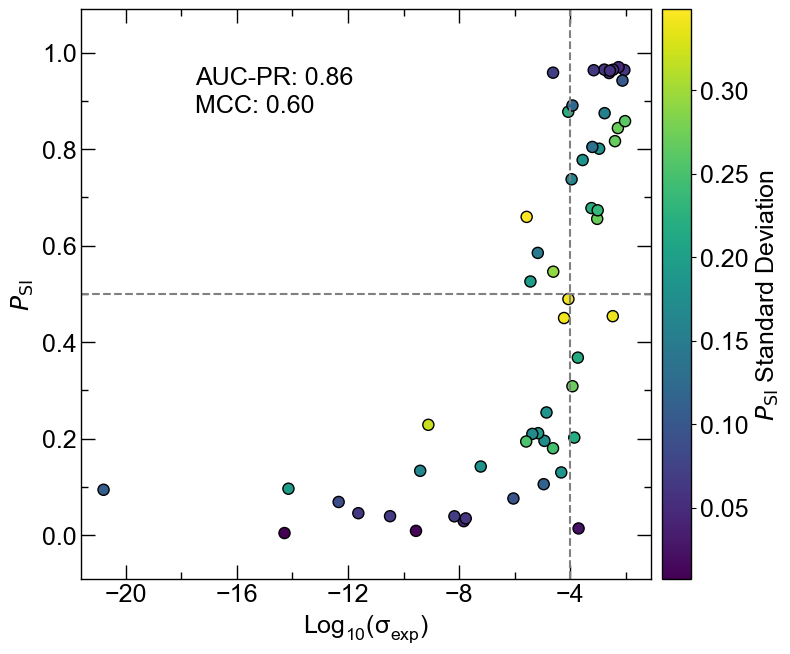

In [11]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 1
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

fig, ax = plt.subplots(figsize=(8, 8))
cmap = plt.cm.viridis

true_labels = test_predictions_df['is_superionic']
predicted_labels = test_predictions_df['predicted_is_superionic']
predicted_probabilities = test_predictions_df['prediction_mean']
precision, recall, _ = precision_recall_curve(true_labels,predicted_probabilities)
pr_auc = auc(recall, precision)
mcc = matthews_corrcoef(true_labels, predicted_labels)

# Scatter plot with colors based on normalized distances
sc = ax.scatter(test_predictions_df['log10conductivity'], 
                test_predictions_df['prediction_mean'], 
                c=(test_predictions_df['prediction_std']), 
                cmap=cmap, 
                marker='o', 
                facecolors='w',
                s=64,
                edgecolors='k',
                label='Test Set')

cax = ax.inset_axes([1.02, 0, 0.05, 1])
cbar = plt.colorbar(sc, cax=cax)
cbar.set_label(r'$\it{P}_{\mathrm{SI}}$ Standard Deviation', fontsize=18)
cbar.ax.tick_params(labelsize=18)
#cbar.set_ticks([0.1, 0.2, 0.3, 0.4])
#cbar.update_ticks()

plt.xticks([-20, -16, -12, -8, -4], fontsize=18)
plt.xlim([-21.6, -1.1])
plt.ylim([-0.09, 1.09])
ax.set_aspect(np.diff(ax.get_xlim()) / np.diff(ax.get_ylim()))

plt.tick_params(axis='both', which='major', direction='in', length=10, width=1, labelsize=18, colors='k', top=True, right=True)
plt.tick_params(axis='both', which='minor', direction='in', length=5, width=1, colors='k', top=True, right=True)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

plt.ylabel(r'$\it{P}_{\mathrm{SI}}$', fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r'Log$_{10}(\sigma_{exp})$', fontsize=18)
plt.hlines(y=0.5, xmin=min(ax.get_xlim()), 
           xmax=max(ax.get_xlim()), color='grey', 
           linestyle='--', linewidth=1.5)

plt.vlines(x=-4, ymin=min(ax.get_ylim()), 
           ymax=max(ax.get_ylim()), color='grey', 
           linestyle='--', linewidth=1.5)

plt.text(0.2, 0.9, f'AUC-PR: {pr_auc:.2f}', fontsize=18, verticalalignment='top', horizontalalignment='left', transform=ax.transAxes)
plt.text(0.2, 0.85, f'MCC: {mcc:.2f}', fontsize=18, verticalalignment='top', horizontalalignment='left', transform=ax.transAxes)
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='w', markeredgecolor='k', markersize=8, label='Test Set')]
#plt.legend(handles=legend_elements, bbox_to_anchor=(0.05, 0.9385), loc='upper left', fontsize=18, frameon=False, handletextpad=0.01)

plt.tight_layout()
plt.savefig('../figures/test_600dpi.tif', dpi=600, bbox_inches='tight')
plt.show()

### Compare to Atomistic Logistic Regression Model

In [52]:
atomistic_results = pd.read_pickle(atomistic_results_filepath)
atomistic_feature_df = pd.read_pickle(atomistic_feature_path)
labelled_conductivity_database_features = pd.read_pickle(labelled_conductivity_database_features_path)

scaler = MinMaxScaler()
atomistic_features_normalized = scaler.fit_transform(atomistic_feature_df.iloc[:, 1:])
atomistic_features_normalized_df = pd.DataFrame(atomistic_features_normalized, columns=atomistic_feature_df.columns[1:])
atomistic_features_normalized_df['icsd_collectioncode'] = atomistic_feature_df['icsd_collectioncode']

test_split_df = pd.read_csv(test_split_path)
test_feature_df = pd.merge(test_split_df, atomistic_features_normalized_df, on='icsd_collectioncode')
test_icsd_collectioncodes = test_feature_df['icsd_collectioncode'].unique()
train_icsd_collectioncodes = labelled_conductivity_database_features[~labelled_conductivity_database_features['icsd_collectioncode'].isin(test_icsd_collectioncodes)]['icsd_collectioncode']
train_feature_df = atomistic_features_normalized_df[atomistic_features_normalized_df['icsd_collectioncode'].isin(train_icsd_collectioncodes)]
train_feature_df = pd.merge(train_feature_df, labelled_conductivity_database_features[['icsd_collectioncode', 'is_superionic']], on='icsd_collectioncode')

In [54]:
max_iter = []
for fold, fold_results in atomistic_results.items():
    best_result = max(fold_results, key=lambda x: x['val_pr_auc'])
    max_iter.append(best_result['max_iter'])
average_best_max_iter = int(np.mean(max_iter))

In [57]:
for fold, fold_results in atomistic_results.items():
    best_result = max(fold_results, key=lambda x: x['val_pr_auc'])
    print(f"Fold {fold}: Best Params: C={best_result['C']}, max_iter={best_result['max_iter']}")
    print(f"Fold {fold}: Validation PR AUC: {best_result['val_pr_auc']}")
    print(f"Fold {fold}: Validation MCC: {best_result['val_mcc']}")

Fold fold_0: Best Params: C=0.655128556859551, max_iter=100
Fold fold_0: Validation PR AUC: 0.5624899800150196
Fold fold_0: Validation MCC: 0.0
Fold fold_1: Best Params: C=33.9322177189533, max_iter=100
Fold fold_1: Validation PR AUC: 0.4448085492088986
Fold fold_1: Validation MCC: 0.11704114719613055
Fold fold_2: Best Params: C=0.001, max_iter=100
Fold fold_2: Validation PR AUC: 0.387326729324327
Fold fold_2: Validation MCC: 0.0
Fold fold_3: Best Params: C=0.28117686979742307, max_iter=100
Fold fold_3: Validation PR AUC: 0.7059017606003584
Fold fold_3: Validation MCC: 0.13045884473731592
Fold fold_4: Best Params: C=0.001, max_iter=100
Fold fold_4: Validation PR AUC: 0.5387081178709786
Fold fold_4: Validation MCC: 0.0
Fold fold_5: Best Params: C=3.5564803062231287, max_iter=100
Fold fold_5: Validation PR AUC: 0.7638888888888888
Fold fold_5: Validation MCC: 0.31622776601683794
Fold fold_6: Best Params: C=0.001, max_iter=100
Fold fold_6: Validation PR AUC: 0.5586268981453185
Fold fold_6:

In [22]:
test_predictions = []

for fold, fold_results in atomistic_results.items():
    set_reproducibility()
    best_result = max(fold_results, key=lambda x: x['val_pr_auc'])
    best_c_param = best_result['C']

    X_train = train_feature_df[['avg_min_li_li_distance', 'avg_min_li_anion_distance', 'avg_num_li_li_bonds', 'avg_ionicity', 'avg_anion_coordination']]
    y_train = train_feature_df['is_superionic']

    X_test = test_feature_df[['avg_min_li_li_distance', 'avg_min_li_anion_distance', 'avg_num_li_li_bonds', 'avg_ionicity', 'avg_anion_coordination']]
    
    best_model = LogisticRegression(C=best_c_param, max_iter=average_best_max_iter)
    best_model.fit(X_train, y_train)
    
    y_test_prob = best_model.predict_proba(X_test)[:, 1]
    test_predictions.append(y_test_prob)

test_predictions_mean = np.mean(test_predictions, axis=0)
test_predictions_std = np.std(test_predictions, axis=0)

y_test = test_feature_df['is_superionic']
precision_test, recall_test, _ = precision_recall_curve(y_test, test_predictions_mean)
pr_auc_test = auc(recall_test, precision_test)
mcc_test = matthews_corrcoef(y_test, (test_predictions_mean > 0.5).astype(int))
accuracy_test = accuracy_score(y_test, (test_predictions_mean > 0.5).astype(int))

print(f"Test PR AUC: {pr_auc_test}")
print(f"Test MCC: {mcc_test}")
print(f"Test Accuracy: {accuracy_test}")

Test PR AUC: 0.8021035953458655
Test MCC: 0.26311740579210874
Test Accuracy: 0.6
